# Scraping from Wikipedia

In [1]:
# Uncomment if beautiful soup, folium, or geopy dependencies are not installed
#!conda install beautifulsoup4 --yes
#!conda install folium -c conda-forge
#!conda install -c conda-forge geopy --yes

In [2]:
#Import dependencies
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

#Everything from the web is JSON, so will import that
import json
from pandas.io.json import json_normalize

#Scrape the table with BeautifulSoup and requests
website = requests.get("http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(website.content,'lxml')
zip_table = soup.find_all('table')[0] 

#use pandas to read a list of dataframes into zip_df
zip_df = pd.read_html(str(zip_table))
#reassign zip_df into the single dataframe in the list
zip_df = zip_df[0]
zip_df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Fulfill assignment requests:

1) Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.


2) More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be combined into one row with the neighborhoods separated with a comma.


3) If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the **Borough** and the **Neighborhood** columns will be **Queen's Park**.


4) Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.


5) In the last cell of your notebook, use the **.shape** method to print the number of rows of your dataframe.


In [3]:
#Delete rows with a borough that is "Not assigned"

zip_df = zip_df[zip_df['Borough'] != 'Not assigned']
zip_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [4]:
# If more than one neighbourhood is assigned to a borough, group by postcode and borough, then join Neighbourhood with a comma

zip_df = zip_df.groupby(['Postcode','Borough']).agg({'Neighbourhood': ','.join})
zip_df.reset_index(inplace=True)
zip_df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
#If a neighbourhood is "Not assigned", then it will be reassigned the Borough name
#Recall: Boroughs that are "Not assigned" have already been deleted

zip_df['Neighbourhood'] = np.where(zip_df.Neighbourhood=='Not assigned',zip_df['Borough'],zip_df['Neighbourhood'])

#Uncomment the following line if you want to see an example of the change in the dataframe
#zip_df.head(100) #look for Queen's Park Borough (index 93), where Neighbourhood was 'Not assigned'


In [6]:
#Printing shape of dataframe, as requested
zip_df.shape

(103, 3)

# Add Latitude and Longitude


Add latitude and longitude from each neighborhood.

In [7]:
#!conda install -c conda-forge geocoder
#Didn't work after multiple calls, so will just load CSV from project page

In [8]:
# Read latitude/longitude information into latlong dataframe and merge with zip_df frame
latlong = pd.read_csv('https://cocl.us/Geospatial_data')
latlong.head()

zip_df = pd.merge(zip_df,latlong,left_on='Postcode', right_on='Postal Code')

#Remove redundant Postal Code column
del (zip_df['Postal Code'])
zip_df.head(12)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


# Put it on the map


Add the above information to the map of Toronto obtained from the Folium library.



In [9]:
# Get Toronto centered on folium map with lat/long from geopy
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="o_can_a_da")
toronto_location = geolocator.geocode(address)
toronto_latitude = toronto_location.latitude
toronto_longitude = toronto_location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [10]:
map_toronto = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(zip_df['Latitude'], zip_df['Longitude'], zip_df['Borough'], zip_df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Note: There really only appears to be a single cluster here, so will need to find a way to differentiate with Foursquare data, otherwise this won't be an interesting analysis**

# Hidden Cell Here


For security purposees, the code containing Client ID and Secret are hidden.

In [11]:
# @ hidden cell 

CLIENT_ID = 'ZERSTUE5EER15TK05FPPWADE0N1HUJY0RUKLLIEJDU4LZA2Z' # your Foursquare ID
CLIENT_SECRET = 'UKX03JKKN1QOLAVO1Q0WLQLU2IS4ZQEIJCG3OQ2JG1KEOPAY' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [12]:
#getNearbyVenues helper function from New York notebook:
def getNearbyVenues(neighbourhoods, latitudes, longitudes, radius=500, limit=50):
    
    venues_list=[]
    for neighbourhood, lat, lng in zip(neighbourhoods, latitudes, longitudes):
        #print(neighbourhood)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighbourhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Nearby Venues

Now that we have a helper function, we can retrieve the venues near each neighborhood.

In [13]:
#Create nearby_venues dataframe using the helper function:

nearby_venues = getNearbyVenues(zip_df['Neighbourhood'],zip_df['Latitude'],zip_df['Longitude'])
nearby_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Scarborough Historical Society,43.788755,-79.162438,History Museum
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [14]:
#nearby_venues['Venue Category'].unique()
print('There are {} unique categories.'.format(len(nearby_venues['Venue Category'].unique())))

There are 255 unique categories.


In [15]:
#Given there are 255 unique categories will one-hot encode things across all categories
#Then, take the mean over the neighborhoods to generate an embedding

# one hot encoding
toronto_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = nearby_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#group and get mean to generate embeddings
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean()
toronto_grouped

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide,King,Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.0,0.0,...,0.040000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
Agincourt,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
"Alderwood,Long Branch",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
"Bathurst Manor,Downsview North,Wilson Heights",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.047619,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
Bayview Village,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
"Bedford Park,Lawrence Manor East",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.020000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000


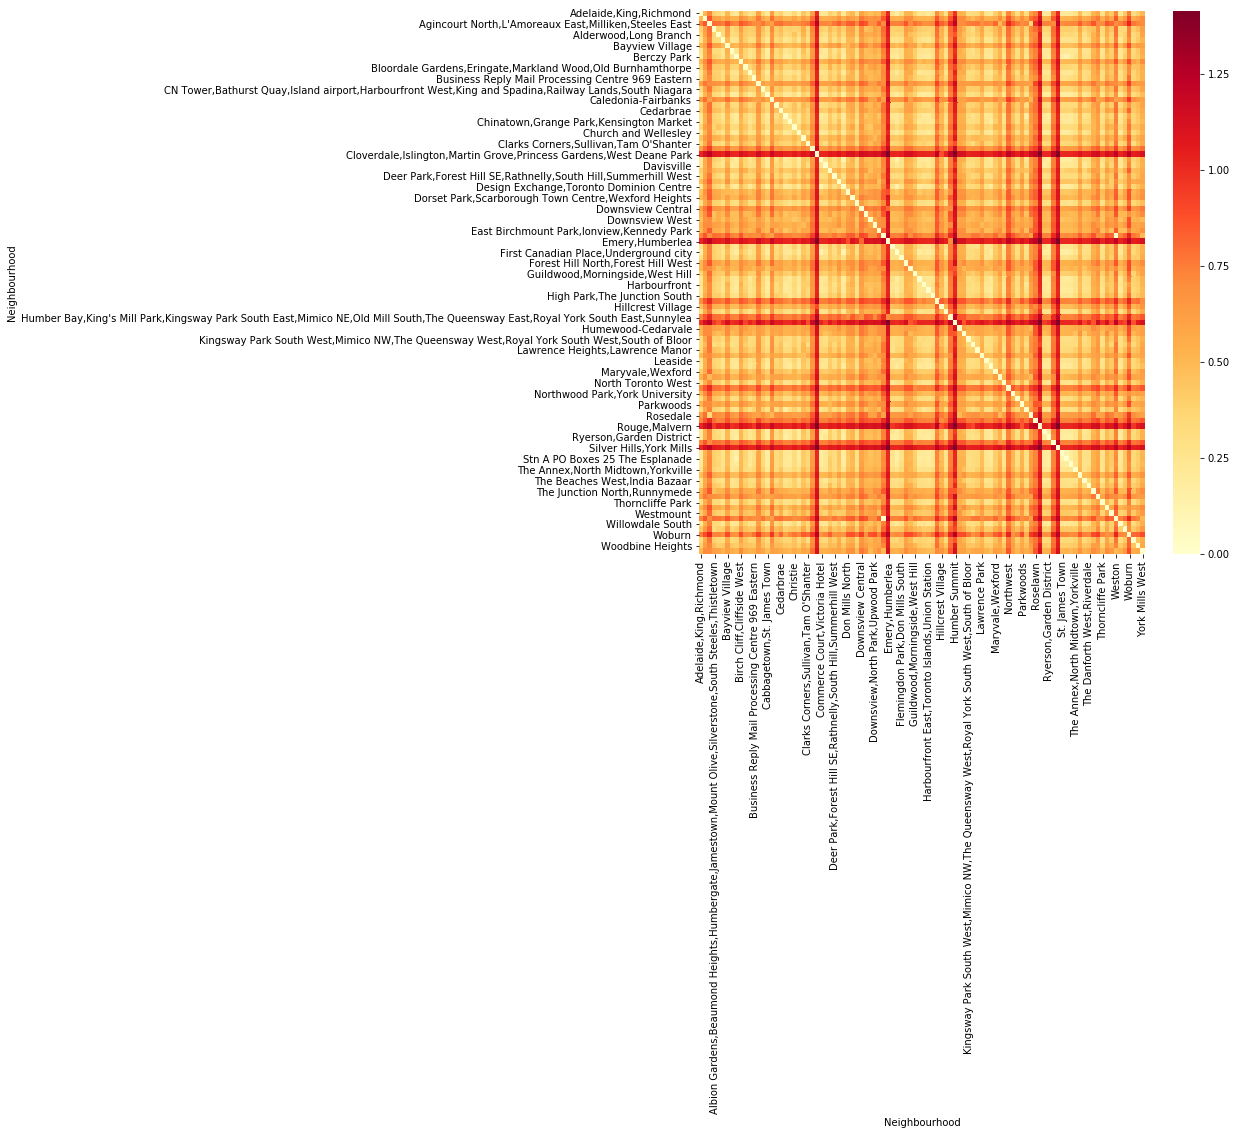

In [16]:
# Get Euclidean distances and see if this makes sense for clustering

embedded_distance_matrix = pd.DataFrame(distance.squareform(distance.pdist(toronto_grouped)),\
                                        columns=toronto_grouped.index,index = toronto_grouped.index)

#embedded_distance_matrix.head()

#Create heatmap with seaborn


plt.figure(figsize=(10,10))
sns.heatmap(embedded_distance_matrix, cmap = 'YlOrRd')

plt.show()

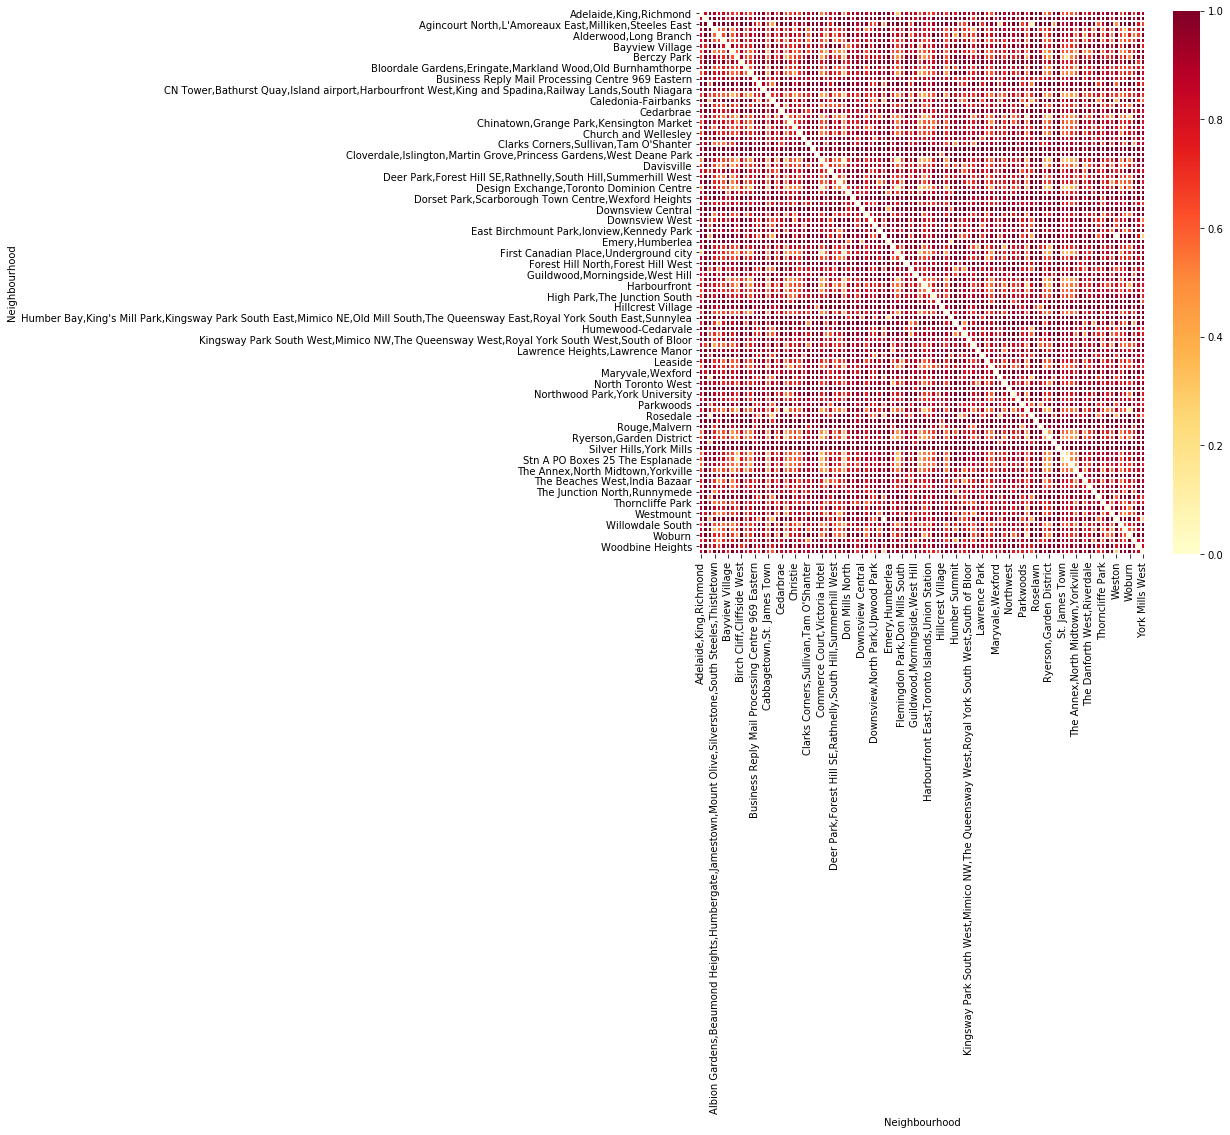

In [17]:
#See if cosine differences give you something much different
# Get Euclidean distances and see if this makes sense for clustering

embedded_distance_matrix = pd.DataFrame(distance.squareform(distance.pdist(toronto_grouped,metric='cosine')),\
                                        columns=toronto_grouped.index,index = toronto_grouped.index)
plt.figure(figsize=(10,10))
sns.heatmap(embedded_distance_matrix, cmap = 'YlOrRd', linewidth = 1)

plt.show()

# Perform  clustering

It appears that we can choose between distance metrics if we want and both will make clusters. Will just have to see performance. Will start with DBSCAN.

In [18]:
NUMBER_CLUSTERS = 5

# Convert DataFrame to numpy array
embeddings = toronto_grouped.values

# Start with 5 clusters, see if this gives us the resolution we need
toronto_k_means = KMeans(n_clusters=NUMBER_CLUSTERS)
toronto_k_means.fit(embeddings)

# Get labels and put into dataframe
labels = toronto_k_means.labels_
cluster_results = pd.DataFrame([toronto_grouped.index,labels]).transpose()
cluster_results.rename(columns={0:'Neighbourhood',1:'Cluster Designation'}, inplace=True)
cluster_results.head()

,Neighbourhood,Cluster Designation
0,"Adelaide,King,Richmond",2
1,Agincourt,2
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",1
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",2
4,"Alderwood,Long Branch",2


In [19]:
#Merge the cluster designations with zip_df

zip_df_test = pd.merge(zip_df,cluster_results,left_on='Neighbourhood', right_on='Neighbourhood')
zip_df_test.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Designation
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,2
3,M1G,Scarborough,Woburn,43.770992,-79.216917,2
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,2


In [20]:
#Just set a reminder for the number of clusters so we know how many colors to label clusters with
print('There are {} unique clusters.'.format(NUMBER_CLUSTERS))

There are 5 unique clusters.


In [21]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(NUMBER_CLUSTERS)
ys = [i + x + (i*x)**2 for i in range(NUMBER_CLUSTERS)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zip_df_test['Latitude'], zip_df_test['Longitude'], \
                                  zip_df_test['Neighbourhood'], zip_df_test['Cluster Designation']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Conclusions

The above clusters change depending on K means initialization. Generally, these are the clusters you would get based on the embeddings we did above. The clusters would likely change if you chose a different embedding method.